In [1]:
# test 

import os
from dotenv import load_dotenv
import geopandas as gpd
import sys
from _downloadsentle_ import sentle_download
from _getdata_harmo_ import getdata_harmonized
from _create_xarray_harmo_ import create_xarray
from _save_xarray_ import save_as_zarr
import torch
import logging

In [10]:
# is for logging
logging.basicConfig(
    level=logging.INFO,  # Set the desired logging level
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(),  # Logs to the console
        logging.FileHandler('sentinel_processing_3.log')  # Logs to a file
    ]
)
logger = logging.getLogger()


# environment
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
torch.cuda.device_count()
# Define working direction path 

load_dotenv()
LUCAS = os.getenv('LUCAS_HARMO')
MINICUBE_OUT= os.getenv('MINICUBE_OUT_HARMO')
# MINICUBE_OUT = os.getenv('MINICUBE_OUT')

lucaspoly = gpd.read_file(f'{LUCAS}/Wheat_harmo_eo4bk.gpkg', layer = 'hd_data')



# change time span of download period
time_span = "2018-01-01/2022-12-31"

# because polygons less then 100 sqm are smaller than one pixel
lucaspoly_ov_100sqm = lucaspoly[lucaspoly['poly_area_sqm'] > 100]

# to have a test subset, only downloads the first two polygons
id_list = list(lucaspoly_ov_100sqm['point_id'])#[:1]

# define the main direction, the save function then builds additional direction inside this direciton 
main_direciton = MINICUBE_OUT

# counter = 0
# function 
def main_function(idx):
    '''
    To execute all the above in the right sequence.
    '''
    global counter
    i = id_list[idx]
    output_download = sentle_download(lcs_eo4bkdata= lucaspoly_ov_100sqm[lucaspoly_ov_100sqm['point_id']== i], time_span = time_span )
    # important to set hd = True when dealing with hd data, and ld when dealing with low detail data. 
    variables = getdata_harmonized(output_download=output_download, lcs_eo4bkdata= lucaspoly_ov_100sqm[lucaspoly_ov_100sqm['point_id']== i])
    # It is less important here, but savings are being made in the wrong direction. 
    xarray_output = create_xarray(variables)
    save_as_zarr(output_eo4bk_minicube=xarray_output, lcs_eo4bkdata= lucaspoly_ov_100sqm[lucaspoly_ov_100sqm['point_id']== i], main_direction=main_direciton, hd = True)
      # Log the counter
    # return variables

In [11]:
main_function(1)

/net/home/dschierbaum/.conda/envs/wp1v3/lib/python3.12/site-packages/sentle/sentle.py:881: UserWarning: Specified top/bottom bounds are not perfectly divisable by specified target_resolution. The resulting coverage will be rounded up to the next pixel value.
  warnings.warn(
/net/home/dschierbaum/.conda/envs/wp1v3/lib/python3.12/site-packages/sentle/sentle.py:888: UserWarning: Specified left/right bounds are not perfectly divisable by specified target_resolution. The resulting coverage will be rounded up to the next pixel value.
  warnings.warn(
/net/home/dschierbaum/.local/lib/python3.12/site-packages/pandas/core/generic.py:3331: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable con

In [1]:
import xarray as xr

minicube = xr.open_zarr('/net/projects/EO4BK/WP1/P1-EO4BK/scripts/EO4BK-WP1-P1/eo4bksentleharmo/Minicube/Wheat/hd/ES/Wheat_ES242_34022044.zarr')


In [5]:
minicube

<xarray.Dataset> Size: 106kB
Dimensions:                               (lat: 3, index: 1, lon: 4, time: 109)
Coordinates:
  * lat                                   (lat) float32 12B 2.044e+06 ... 2.0...
  * lon                                   (lon) float32 16B 3.402e+06 ... 3.4...
  * time                                  (time) datetime64[ns] 872B 2022-12-...
Dimensions without coordinates: index
Data variables: (12/52)
    lcs_geometry                          (index) <U3647 15kB dask.array<chunksize=(1,), meta=np.ndarray>
    lcs_lc1_2018                          (index) <U3 12B dask.array<chunksize=(1,), meta=np.ndarray>
    lcs_lc1_2022                          (index) <U18 72B dask.array<chunksize=(1,), meta=np.ndarray>
    lcs_lc1_spec_2018                     (index) <U16 64B dask.array<chunksize=(1,), meta=np.ndarray>
    lcs_lc1_spec_2022                     (index) <U16 64B dask.array<chunksize=(1,), meta=np.ndarray>
    lcs_lc2_2018                          (index) <U16 64B dask.array<chunksize=(1,), meta=np.ndarray>
    ...                                    ...
    sent_b12                              (time, lat, lon) float32 5kB dask.array<chunksize=(1, 3, 4), meta=np.ndarray>
    sent_kndvi                            (time, lat, lon) float32 5kB dask.array<chunksize=(1, 3, 4), meta=np.ndarray>
    sent_ndvi                             (time, lat, lon) float32 5kB dask.array<chunksize=(1, 3, 4), meta=np.ndarray>
    sent_nirv                             (time, lat, lon) float32 5kB dask.array<chunksize=(1, 3, 4), meta=np.ndarray>
    sent_vh                               (time, lat, lon) float32 5kB dask.array<chunksize=(1, 3, 4), meta=np.ndarray>
    sent_vv                               (time, lat, lon) float32 5kB dask.array<chunksize=(1, 3, 4), meta=np.ndarray>
Attributes:
    Description:     Data variables with the prefix "sent_" are referring to ...
    acknowledgment:  All EO4BK data providers are acknowledged inside each va...

Text(0.5, 1.0, 'NDVI, kNDVI for one Minicube, 2018-2022')

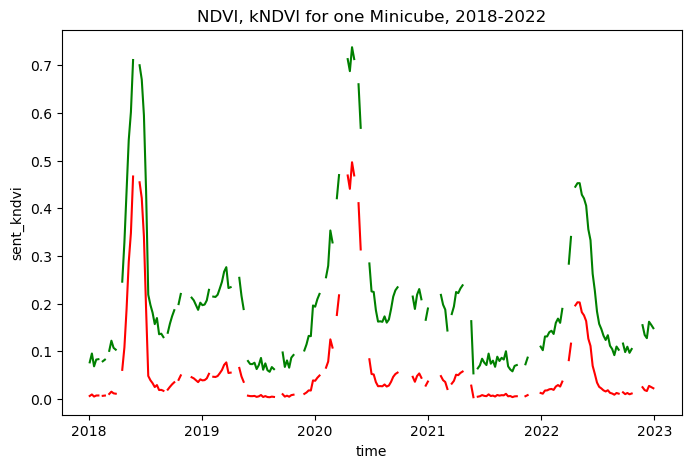

In [4]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (8,5))

# E04BK_ES42_wheat[E04BK_ES42_keys[location]].sent_ndvi.mean(dim =("lat", "lon")).plot( ax= ax, color = "red")

minicube.sent_ndvi.mean(dim =["lat", "lon"]).plot( ax= ax, color = 'green')
minicube.sent_kndvi.mean(dim =["lat", "lon"]).plot( ax= ax, color = 'red')

ax.set_title('NDVI, kNDVI for one Minicube, 2018-2022')